# Necessary libraries

In [ ]:
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 
!pip install category-encoders -q
!pip install shap -q
!pip install imblearn

# EDA Class

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost 
from sklearn.model_selection import StratifiedKFold 
from pylab import rcParams
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.preprocessing import power_transform
rcParams['figure.figsize'] = 10, 10 
from sklearn.preprocessing import *
from tqdm.notebook import tqdm
from sklearn.preprocessing import KBinsDiscretizer
from category_encoders import *
from imblearn.over_sampling import *
from scipy.stats import *
import seaborn as sns
from pandas_profiling import ProfileReport

class HangiKrediEDA:
    def __init__(self):
        self.train_df = pd.read_csv("/content/drive/My Drive/Hangikredi Task/term-deposit-marketing-2020.csv")
        self.train_df["y"] = self.train_df["y"].map({"yes": 1, "no": 0})
        self.target = "y"
        self.numeric_cols = ["age", "balance", "duration"]
        self.cat_cols = ["housing", 'loan', 'contact', 'day', 'month', "marital", "job", "campaign"]
        
    def get_df_profile(self):
        profile = ProfileReport(self.train_df, title="HangiKredi Dataset", html = {"style": {"full_width": True}})
        profile.to_notebook_iframe()
        profile.to_file(output_file="HangiKredi_full.html")
    
    def target_distribution(self):
        sns.countplot(x=self.target, data=self.train_df)
        print(self.train_df[self.target].value_counts(normalize=True))
    
    def pointbiserial_correlations(self):
        for col in ['age', 'balance', 'day', 'duration', 'campaign']:
            print("Correlation between y and " + col + " : {}".format(pointbiserialr(self.train_df[self.target], self.train_df[col])[0]))
            print(20*'-')
    
    def baseline_model(self):
        # prepare stratified kfold
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        X = self.train_df["duration"].values
        y = self.train_df[self.target].values
        skf.get_n_splits(X, y)
        
        # training - testing
        results_skfold = []
        for train_index, test_index in skf.split(X, y):
            # slice training & test data
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # fit model
            model = LGBMClassifier(is_unbalance=True)
            model.fit(X_train.reshape(-1,1), y_train)

            # get predictions
            results_skfold.append(balanced_accuracy_score(y_test, model.predict(X_test.reshape(-1,1)), adjusted=True))

            feature_importances = pd.DataFrame(model.feature_importances_,
                                               index = ["duration"],
                                               columns=['importance']).sort_values('importance', ascending=False)
            #print(feature_importances)
        
        print("5-fold Mean baseline balanced accuracy: %.2f%%" % (np.mean(results_skfold)*100.0))
    
    def model_continuous_features(self, extra_cols):
        # prepare stratified kfold
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        X = self.train_df[["duration"] + extra_cols].values
        y = self.train_df[self.target].values
        skf.get_n_splits(X, y)
        
        # training - testing
        results_skfold = []
        for train_index, test_index in skf.split(X, y):
            # slice training & test data
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # fit model
            model = LGBMClassifier(is_unbalance=True)
            model.fit(X_train, y_train)

            # get predictions
            results_skfold.append(balanced_accuracy_score(y_test, model.predict(X_test), adjusted=True))
        print("5-fold Mean baseline balanced accuracy: %.2f%%" % (np.mean(results_skfold)*100.0))

eda = HangiKrediEDA()        

# Data Inspection

In [ ]:
eda.train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,0


In [ ]:
eda.train_df.shape

(40000, 14)

In [ ]:
eda.train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 4.3+ MB


In [ ]:
"""
basic EDA & descriptive statistics can be viewed via Jupyter Notebook Viewer by pandas profiling
"""
eda.get_df_profile()

# Target variable distribution

0    0.9276
1    0.0724
Name: y, dtype: float64


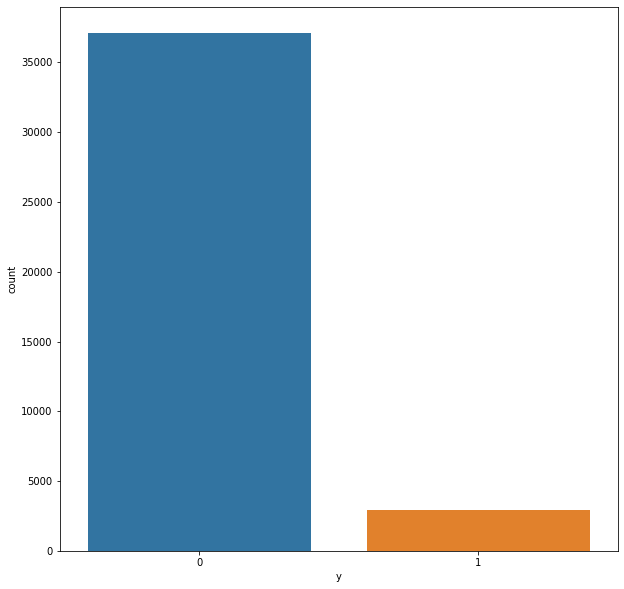

In [ ]:
eda.target_distribution() # balanced accuracy should be used.

# Correlations between numeric variables and y

In [ ]:
eda.pointbiserial_correlations() # correlation between a continuous variable & dichotomous variable y

Correlation between y and age : -0.020272758609339338
--------------------
Correlation between y and balance : 0.030231775493465587
--------------------
Correlation between y and day : -0.006419829994187769
--------------------
Correlation between y and duration : 0.4611693643409482
--------------------
Correlation between y and campaign : -0.04035025879326462
--------------------


In [ ]:
eda.train_df["duration"].describe()

count    40000.000000
mean       254.824300
std        259.366498
min          0.000000
25%        100.000000
50%        175.000000
75%        313.000000
max       4918.000000
Name: duration, dtype: float64

### duration varies between 0 seconds and 4918 seconds. With domain information, the minimum and maximum time can be restricted to a reasonable range. Still, duration shows a considerable correlation with y. A baseline model can be constructed with this feature.

# Constructing Baseline model

In [ ]:
"""
feature: [duration]
pipeline: StratifiedKFold - 5 folds
model: LightGBM, default params w/ is_unbalance=True (recommended for imbalanced binary classification)
metric: balanced accuracy (for imbalanced binary classification)
"""
eda.baseline_model()

5-fold Mean baseline balanced accuracy: 79.13%


# Adding continuous features to baseline model

### The middle age group tends to make y = 1 more than the younger and older people. Therefore, age information can be added to the system as a continuous feature.

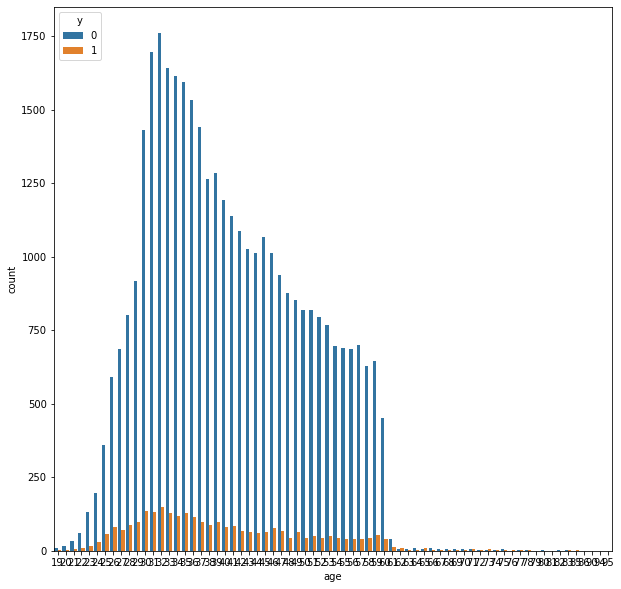

In [ ]:
import seaborn as sns

sns.countplot(x='age', hue='y', data=eda.train_df)

### The mean ratio of y = 1 at the beginning days of the month and at the end days of the month is higher than the middle days of the month, so "day" can be used as a continuous feature.

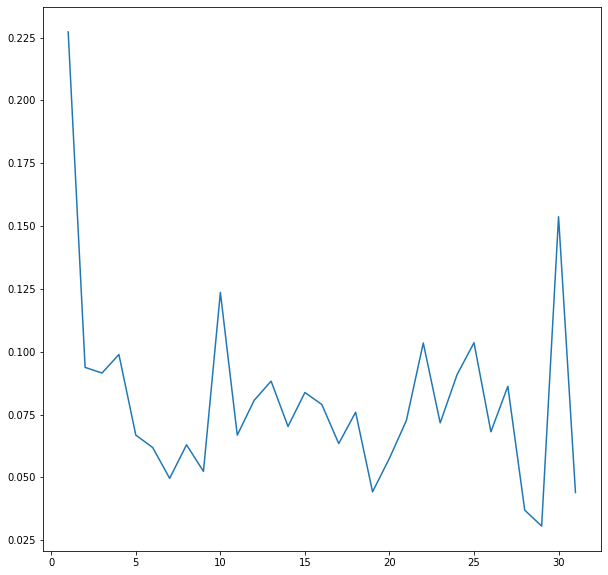

In [64]:
import matplotlib.pyplot as plt
day_y_df = eda.train_df.groupby("day")["y"].mean()

plt.plot(day_y_df.index, day_y_df.values)

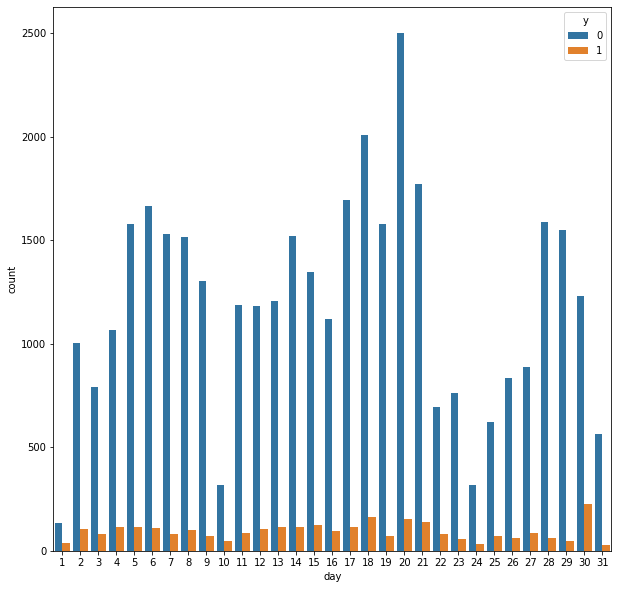

In [68]:
import seaborn as sns

sns.countplot(x='day', hue='y', data=eda.train_df)

### The average annual balance in euros after a certain amount has an effect that makes y = 0 directly, it can be added to the system as a continuous feature.

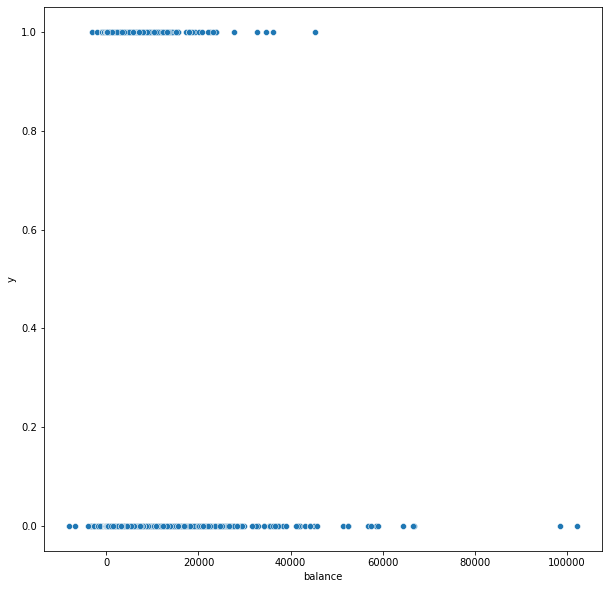

In [ ]:
import seaborn as sns

sns.scatterplot(x='balance', y='y', data=eda.train_df)

### Tendency for y = 1 decreases as number of campaigns increases.

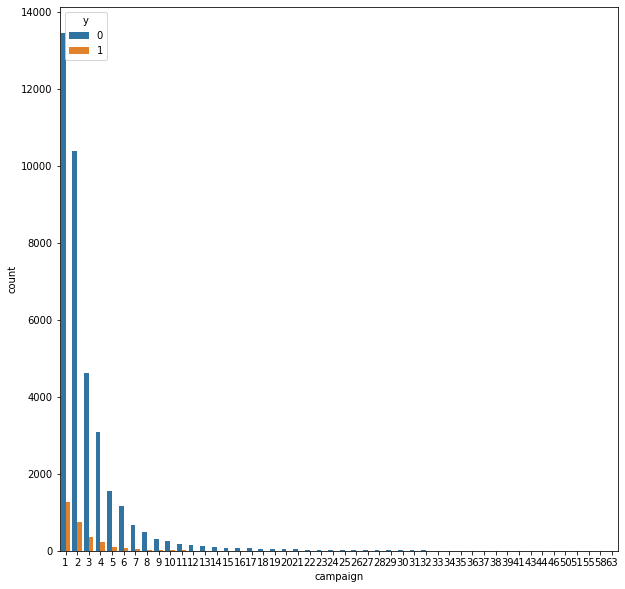

In [144]:
sns.countplot(x='campaign', hue='y', data=eda.train_df); 

### model training with new continuous features

In [130]:
"""
feature: [duration, balance, age, day, "campaign"]
pipeline: StratifiedKFold - 5 folds
model: LightGBM, default params w/ is_unbalance=True (recommended for imbalanced binary classification)
metric: balanced accuracy (for imbalanced binary classification)
"""
print(eda.model_continuous_features(["age", "day", "balance", "campaign"]))

5-fold Mean baseline balanced accuracy: 82.60%
None


# Categorical features

### housing

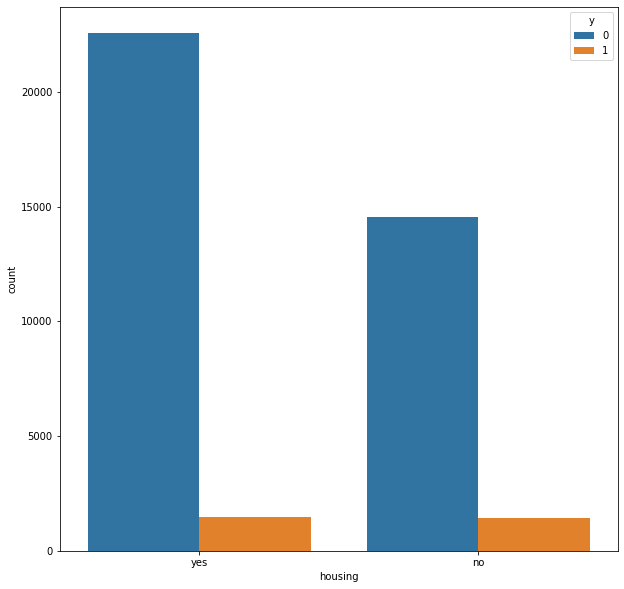

In [163]:
sns.countplot(x='housing', hue='y', data=eda.train_df); 

### loan

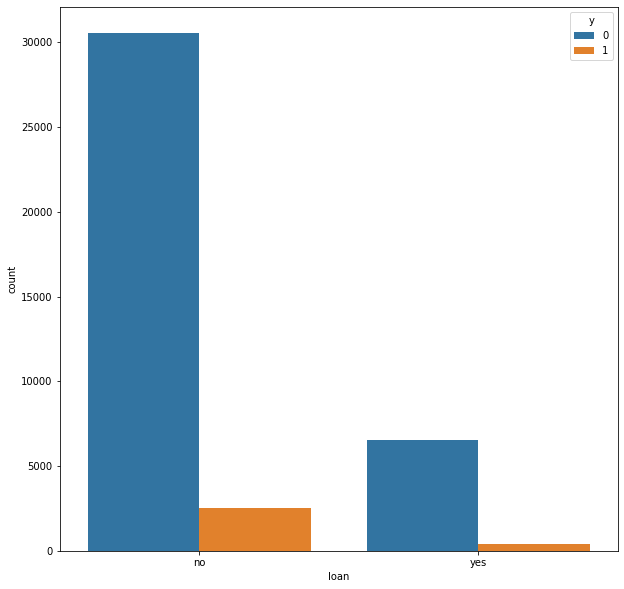

In [164]:
sns.countplot(x='loan', hue='y', data=eda.train_df); 

### telephone calls will be merged w/ unknown as being a low frequency factor

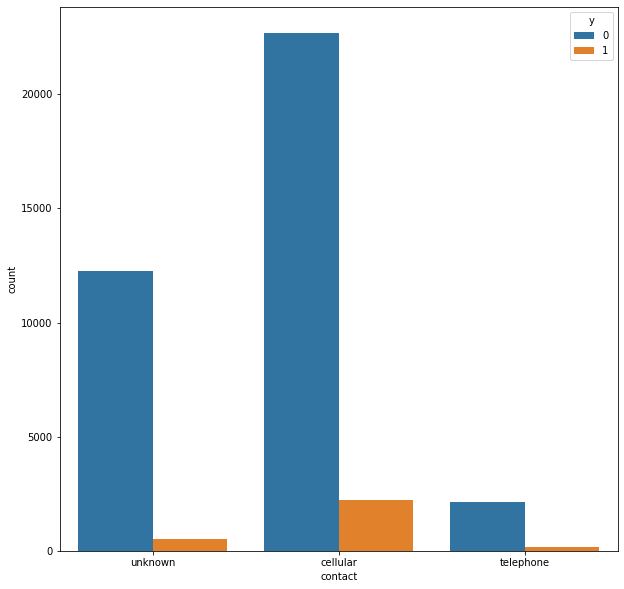

In [153]:
sns.countplot(x='contact', hue='y', data=eda.train_df); 

### divorced will be merged w/ single as being a low frequency factor

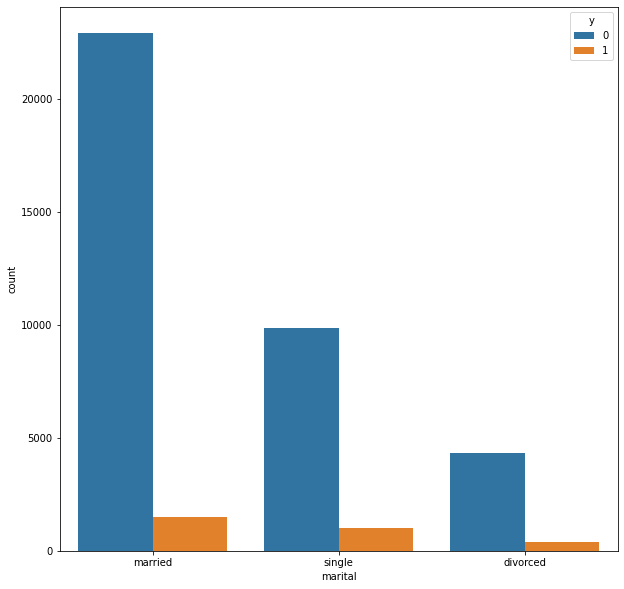

In [211]:
sns.countplot(x='marital', hue='y', data=eda.train_df); 

### primary & unknown will be merged into primary as "unknown" being a low frequency factor

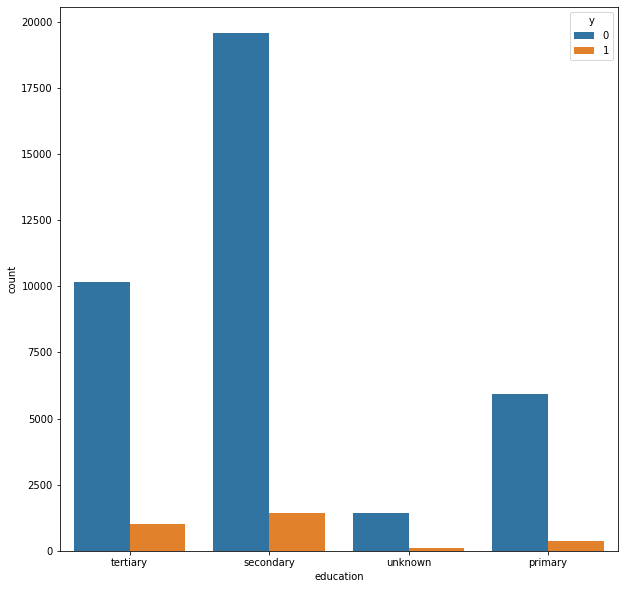

In [212]:
sns.countplot(x='education', hue='y', data=eda.train_df); 

### low frequency factors of job will be merged into "Other"

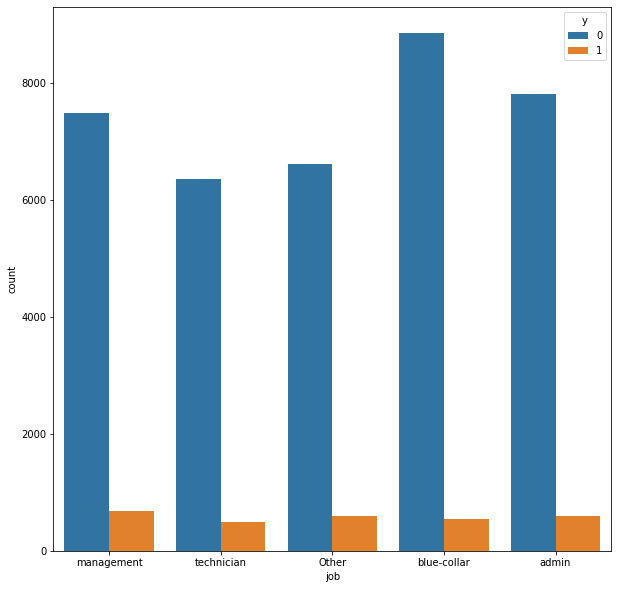

In [199]:
# set up the threshold percent
threshold_percent = 5
series = pd.value_counts(clf.train_df['job'])
mask = (series / series.sum() * 100).lt(threshold_percent)
clf.train_df = clf.train_df.assign(job = np.where(clf.train_df['job'].isin(series[mask].index),'Other', clf.train_df['job']))
clf.train_df["job"] = [elem if elem != "admin" and elem != "services" else "admin" for elem in clf.train_df["job"]]
sns.countplot(x='job', hue='y', data=clf.train_df);

# Model w/ continuous & categorical features

In [57]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold 
from pylab import rcParams
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.preprocessing import *
from category_encoders import *
from scipy.stats import *
import seaborn as sns
import shap
from imblearn.over_sampling import *
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

class HangiKrediModel:
    def __init__(self):
        self.train_df = pd.read_csv("/content/drive/My Drive/Hangikredi Task/term-deposit-marketing-2020.csv")
        self.train_df["y"] = self.train_df["y"].map({"yes": 1, "no": 0})
        self.train_df["housing"] = self.train_df["housing"].map({"yes": 1, "no": 0})
        self.train_df["loan"] = self.train_df["loan"].map({"yes": 1, "no": 0})

        self.target = "y"
        self.numeric_cols = ["age", "day", "duration", "campaign", "balance"]
        self.cat_cols = ["housing", "contact", "loan", "month", "education", "job", "marital"]
        self.feature_importance_dfs = []
        self.feature_importance_dict = {}
        self.contact_dict = {"cellular":1, "unknown":0}
        self.marital_dict = {"single":0, "married":1}
        self.education_dict = {"secondary":1, "tertiary":2, "unknown":0, "primary":0}
        self.job_dict = {'management':0, 'technician':1, "Other":2, "blue-collar":3, "admin": 4} 
        self.month_dict = {'may':1, 'jun':2, 'jul':2, 'aug':2, 'oct':3, 'nov':3, 'dec':0, 'jan':0, 'feb':0, 'mar':1, 'apr':1}

        # set up the threshold percent
        threshold_percent = 5
        series = pd.value_counts(self.train_df['job'])
        mask = (series / series.sum() * 100).lt(threshold_percent)
        self.train_df = self.train_df.assign(job = np.where(self.train_df['job'].isin(series[mask].index),'Other', self.train_df['job']))
        self.train_df["job"] = [elem if elem != "admin" and elem != "services" else "admin" for elem in self.train_df["job"]]
    
    @staticmethod
    def apply_contact_part1(x):
        return x if x != "telephone" else "unknown"

    def apply_contact_part2(self, x):
        return self.contact_dict[x]
    
    @staticmethod
    def apply_marital_part1(x):
        return x if x != "divorced" else "single"

    def apply_marital_part2(self, x):
        return self.marital_dict[x]
    
    def apply_month(self, x):
        return self.month_dict[x]
    
    def apply_education(self, x):
        return self.education_dict[x]

    def apply_job(self, x):
        return self.job_dict[x]
    
    def model_fitting(self):

        #drop duplicates if it exists
        self.train_df.drop_duplicates(subset=None, keep="first", inplace=True)

        #dropped rows where duration was zero (4 rows)
        self.train_df = self.train_df[~(self.train_df['duration']==0)] 

        # prepare stratified kfold
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

        # merging telephone w/ unknown
        self.train_df["contact"] = self.train_df["contact"].apply(lambda x: self.apply_contact_part1(x))
        self.train_df["contact"] = self.train_df["contact"].apply(lambda x: self.apply_contact_part2(x))

        # merging divorced w/ single
        self.train_df["marital"] = self.train_df["marital"].apply(lambda x: self.apply_marital_part1(x))
        self.train_df["marital"] = self.train_df["marital"].apply(lambda x: self.apply_marital_part2(x))
        
        # merging months as seasons
        self.train_df["month"] = self.train_df["month"].apply(lambda x: self.apply_month(x))
        self.train_df["education"] = self.train_df["education"].apply(lambda x: self.apply_education(x))
        self.train_df["job"] = self.train_df["job"].apply(lambda x: self.apply_job(x))


        X = self.train_df[self.numeric_cols + self.cat_cols].values
        y = self.train_df[self.target].values
        skf.get_n_splits(X, y)
        
        # training - testing
        results_skfold = []
        for train_index, test_index in tqdm(skf.split(X, y)):
            # slice training & test data
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            X_train = pd.DataFrame(X_train, columns=self.numeric_cols + self.cat_cols)
            X_test = pd.DataFrame(X_test, columns=self.numeric_cols + self.cat_cols)
        
            # fit model
            model = LGBMClassifier(is_unbalance=True)
            model.fit(X_train, y_train)

            # get predictions
            results_skfold.append(balanced_accuracy_score(y_test, model.predict(X_test.values)))

            # get feature importances for this model
            feature_importances = pd.DataFrame(model.feature_importances_,
                                               index = self.numeric_cols + self.cat_cols,
                                               columns=['importance']).sort_values('importance', ascending=False)
            
            self.feature_importance_dfs.append(feature_importances)
            
        print(results_skfold)
        print("5-fold Final mean test balanced accuracy: %.2f%%" % (np.mean(results_skfold)*100.0))
        return model, X_train

"""
numeric features: ["age", "day", "duration", "campaign", "balance"]
categorical features: ["housing", "contact", "loan", "month", "education", "job", "marital"]
pipeline: StratifiedKFold - 5 folds
model: LightGBM, default params w/ is_unbalance=True (recommended for imbalanced binary classification)
metric: balanced accuracy (for imbalanced binary classification)
"""
clf = HangiKrediModel()
lightgbm_model, X_train = clf.model_fitting()


[0.8816376482832758, 0.8810275118505437, 0.8736003845276501, 0.8764855057283447, 0.8788791437975132]
5-fold Final mean test balanced accuracy: 87.83%


# What makes the customers buy?

In [58]:
# Averaging feature importances for models in all folds

print("Feature Importances Overall (%)")
all_dfs = pd.concat(clf.feature_importance_dfs, axis=1)
all_dfs['importance_mean'] = all_dfs.mean(axis=1)
all_dfs['importance_mean'] /= sum(all_dfs['importance_mean'])
all_dfs['importance_mean'] *= 100
all_dfs = all_dfs.sort_values(by=['importance_mean'], ascending=False)
all_dfs["importance_mean"]

Feature Importances Overall (%)


duration     22.846667
balance      17.620000
day          16.866667
age          12.286667
month         8.880000
campaign      6.060000
contact       3.960000
job           3.566667
education     2.720000
housing       2.213333
marital       1.780000
loan          1.200000
Name: importance_mean, dtype: float64

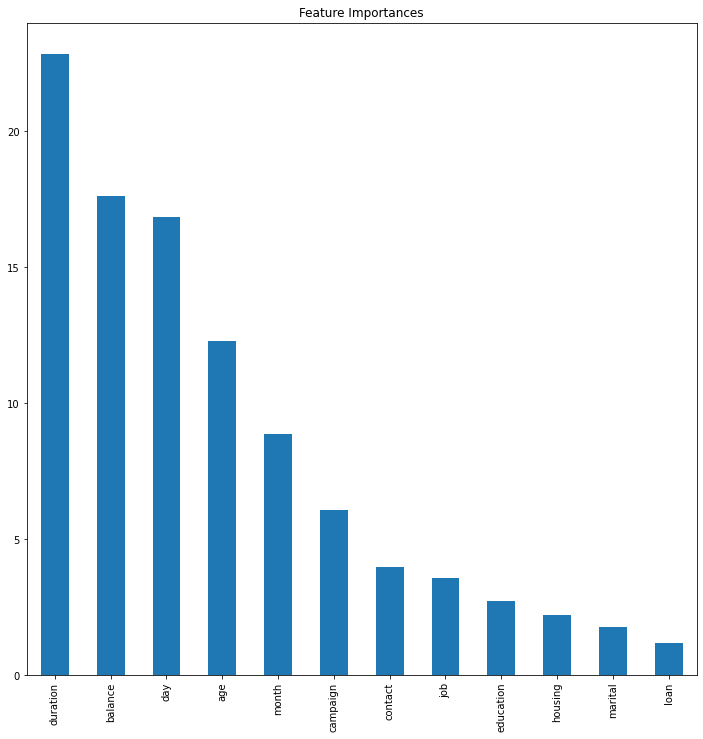

In [59]:
all_dfs['importance_mean'].plot.bar(title="Feature Importances", figsize=(12, 12))

### Feature characteristics for y = 1

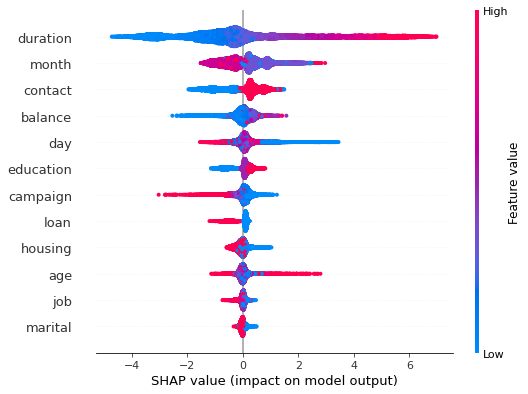

In [60]:
import shap
shap_values = shap.TreeExplainer(lightgbm_model).shap_values(X_train.values)
shap.summary_plot(shap_values[1], X_train)

### For y = 1,

*   Higher values of "duration" (The longer the campaign can be promoted to the customer, the more convinced the customer will be or vice versa.) 
*   Lower values of "month" (winter or spring seasons should be considered)
*   Higher values of "contact" (cellular contact is better than others)
*   Lower values of "day" (More tendency to accept the campaign towards the beginning of a month)
*   Higher values of "education" (tertiary > secondary > primary, possibly related with the increasing salary level as the education level)
*   Higher values of "balance" (People who like to accumulate money in their accounts are more likely to accept the campaign.)
*   Lower values of "campaign" (Intuitively, customers don't want to be overly disturbed)
*   Lower values of "housing" (No housing loan)
*   Lower values of "loan" (No personal loan)
*   Higher values of "age" (Elders are more inclined to accept the campaign)
*   Lower values of "marital" (Being single)
*   Lower values of job (management and technician customers)



can be considered closely.